In [172]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [173]:
#Extract Data From API
key = 'f9b723b76349dcbdfd4ecb614b82f4904b7f9c1e'
df = pdr.get_data_tiingo('MSFT', api_key = key)
df.to_csv('MSFT Historical Prices')
df = pd.read_csv('MSFT Historical Prices')
df = pd.DataFrame(df)
df

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,MSFT,2015-07-24 00:00:00+00:00,45.94,46.320,45.80,45.91,32333244,41.581320,41.925267,41.454603,41.554167,32333244,0.0,1.0
1,MSFT,2015-07-27 00:00:00+00:00,45.35,46.010,45.25,45.94,39701420,41.047298,41.644679,40.956786,41.581320,39701420,0.0,1.0
2,MSFT,2015-07-28 00:00:00+00:00,45.34,45.639,44.79,45.58,34328948,41.038247,41.308878,40.540430,41.255476,34328948,0.0,1.0
3,MSFT,2015-07-29 00:00:00+00:00,46.29,46.780,45.26,45.40,40945864,41.898113,42.341623,40.965837,41.092554,40945864,0.0,1.0
4,MSFT,2015-07-30 00:00:00+00:00,46.88,47.400,45.93,46.26,39777883,42.432135,42.902799,41.572269,41.870959,39777883,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,MSFT,2020-07-15 00:00:00+00:00,208.04,211.330,205.03,209.56,32248900,208.040000,211.330000,205.030000,209.560000,32248900,0.0,1.0
1253,MSFT,2020-07-16 00:00:00+00:00,203.92,205.700,202.31,205.40,29940700,203.920000,205.700000,202.310000,205.400000,29940700,0.0,1.0
1254,MSFT,2020-07-17 00:00:00+00:00,202.88,205.040,201.39,204.47,31636100,202.880000,205.040000,201.390000,204.470000,31636100,0.0,1.0
1255,MSFT,2020-07-20 00:00:00+00:00,211.60,212.300,203.01,205.00,36386100,211.600000,212.300000,203.010000,205.000000,36386100,0.0,1.0


In [174]:
#Data Clean-up/ Preprocessing 
df.columns = map(lambda x: str(x).capitalize(), df.columns)
df.rename(columns = {'Close price': 'Close'}, inplace = True)
df.shape # 1257 trading days in dataset 
df['Date'] = pd.to_datetime(df['Date']).dt.date
df.dropna() #drop all n/a values 
null_check = df.isnull()
#Checking for Missing Values
for column in null_check.columns.values.tolist():
    print (null_check[column].value_counts())  
df

False    1257
Name: Symbol, dtype: int64
False    1257
Name: Date, dtype: int64
False    1257
Name: Close, dtype: int64
False    1257
Name: High, dtype: int64
False    1257
Name: Low, dtype: int64
False    1257
Name: Open, dtype: int64
False    1257
Name: Volume, dtype: int64
False    1257
Name: Adjclose, dtype: int64
False    1257
Name: Adjhigh, dtype: int64
False    1257
Name: Adjlow, dtype: int64
False    1257
Name: Adjopen, dtype: int64
False    1257
Name: Adjvolume, dtype: int64
False    1257
Name: Divcash, dtype: int64
False    1257
Name: Splitfactor, dtype: int64


,Symbol,Date,Close,High,Low,Open,Volume,Adjclose,Adjhigh,Adjlow,Adjopen,Adjvolume,Divcash,Splitfactor
0,MSFT,2015-07-24,45.94,46.320,45.80,45.91,32333244,41.581320,41.925267,41.454603,41.554167,32333244,0.0,1.0
1,MSFT,2015-07-27,45.35,46.010,45.25,45.94,39701420,41.047298,41.644679,40.956786,41.581320,39701420,0.0,1.0
2,MSFT,2015-07-28,45.34,45.639,44.79,45.58,34328948,41.038247,41.308878,40.540430,41.255476,34328948,0.0,1.0
3,MSFT,2015-07-29,46.29,46.780,45.26,45.40,40945864,41.898113,42.341623,40.965837,41.092554,40945864,0.0,1.0
4,MSFT,2015-07-30,46.88,47.400,45.93,46.26,39777883,42.432135,42.902799,41.572269,41.870959,39777883,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,MSFT,2020-07-15,208.04,211.330,205.03,209.56,32248900,208.040000,211.330000,205.030000,209.560000,32248900,0.0,1.0
1253,MSFT,2020-07-16,203.92,205.700,202.31,205.40,29940700,203.920000,205.700000,202.310000,205.400000,29940700,0.0,1.0
1254,MSFT,2020-07-17,202.88,205.040,201.39,204.47,31636100,202.880000,205.040000,201.390000,204.470000,31636100,0.0,1.0
1255,MSFT,2020-07-20,211.60,212.300,203.01,205.00,36386100,211.600000,212.300000,203.010000,205.000000,36386100,0.0,1.0


Text(0, 0.5, 'Price ($)')

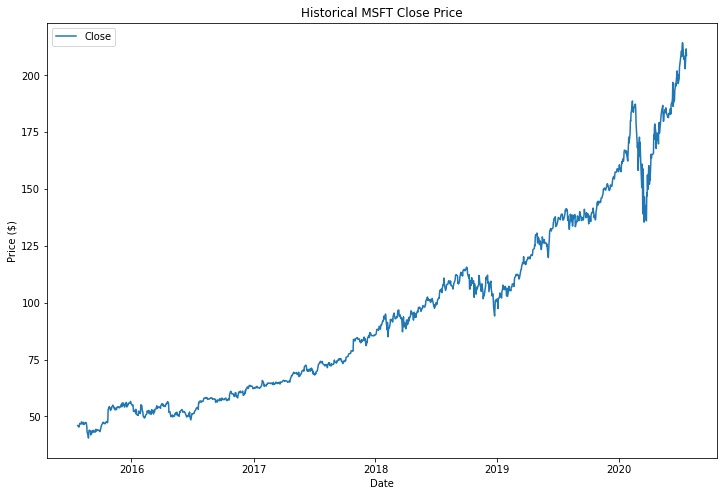

In [175]:
#Visualizing Closing Price History 
df_plot_close = df[['Close', 'Date']]
df_plot_close.plot(kind = 'line', x = 'Date', y = 'Close')
plt.gcf().set_size_inches(12, 8)
plt.title('Historical MSFT Close Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')

In [176]:
#Normalization - MinMaxScaler
df_close = df[['Close', 'Date']]
df_close.set_index('Date', inplace = True)
mms = MinMaxScaler(feature_range = (0,1))
scaled_close = mms.fit_transform(df_close).reshape(-1,1)


In [177]:
#Splitting Train vs Test Data
train_ratio = 0.80
rolling = 60
train_data = np.array(scaled_close[:int(len(df_close)*train_ratio)])
test_data = np.array(scaled_close[int(len(train_data))-rolling:])

#Shapes
traind_shape = train_data.shape
tstd_shape = test_data.shape 
traind_shape, tstd_shape


((1005, 1), (312, 1))

In [178]:
#Seperating x/y Training Sets
x_train = []
y_train = []
for i in range(rolling, len(train_data)):
    x_train.append(train_data[i-rolling:i,0])
    y_train.append(train_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train_shape = x_train.shape[0]
x_train = np.reshape(x_train, (x_train_shape, rolling, 1))
y_train = np.reshape(y_train, (-1,1))

In [179]:
#Seperating x/y Testing Sets
x_test = []
y_test = df_close[int(len(train_data)):]
for i in range(rolling, len(test_data)):
    x_test.append(test_data[i-rolling:i])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test_shape = x_test.shape[0]
x_test = np.reshape(x_test, (x_test_shape, rolling, 1))
y_test = np.reshape(y_test, (-1,1))

In [180]:
#LSTM Model
lstm = Sequential()
lstm.add(LSTM(rolling, return_sequences = True, input_shape = (rolling, 1)))
lstm.add(LSTM(rolling, return_sequences = True))
lstm.add(LSTM(rolling))
lstm.add(Dense(1))
lstm.compile(optimizer = 'adam', loss = 'mse', metrics = ['mean_squared_error'])


In [181]:
#LSTM Model Summary
lstm.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 60, 60)            14880     
_________________________________________________________________
lstm_25 (LSTM)               (None, 60, 60)            29040     
_________________________________________________________________
lstm_26 (LSTM)               (None, 60)                29040     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 61        
Total params: 73,021
Trainable params: 73,021
Non-trainable params: 0
_________________________________________________________________


In [182]:
#LSTM Model Fitting
lstm.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=rolling,batch_size=64,verbose=1)

Epoch 1/60
15/15 [==============================] - 2s 149ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - val_loss: 26399.9785 - val_mean_squared_error: 26399.9785
Epoch 2/60
15/15 [==============================] - 1s 95ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 26347.2812 - val_mean_squared_error: 26347.2812
Epoch 3/60
15/15 [==============================] - 1s 98ms/step - loss: 4.2577e-04 - mean_squared_error: 4.2577e-04 - val_loss: 26332.5156 - val_mean_squared_error: 26332.5156
Epoch 4/60
15/15 [==============================] - 1s 95ms/step - loss: 2.8760e-04 - mean_squared_error: 2.8760e-04 - val_loss: 26332.3730 - val_mean_squared_error: 26332.3730
Epoch 5/60
15/15 [==============================] - 1s 95ms/step - loss: 2.3322e-04 - mean_squared_error: 2.3322e-04 - val_loss: 26336.3223 - val_mean_squared_error: 26336.3223
Epoch 6/60
15/15 [==============================] - 1s 95ms/step - loss: 2.2279e-04 - mean_squared_error: 2.2279e-04 - val_loss: 2

In [186]:
#Train/ Test Data Predictions
x_train_p = lstm.predict(x_train)
x_test_p = lstm.predict(x_test)

In [187]:
#Rescaling Data
x_train_p = mms.inverse_transform(x_train_p)
x_test_p = mms.inverse_transform(x_test_p)
y_train_scaled = mms.inverse_transform(y_train)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


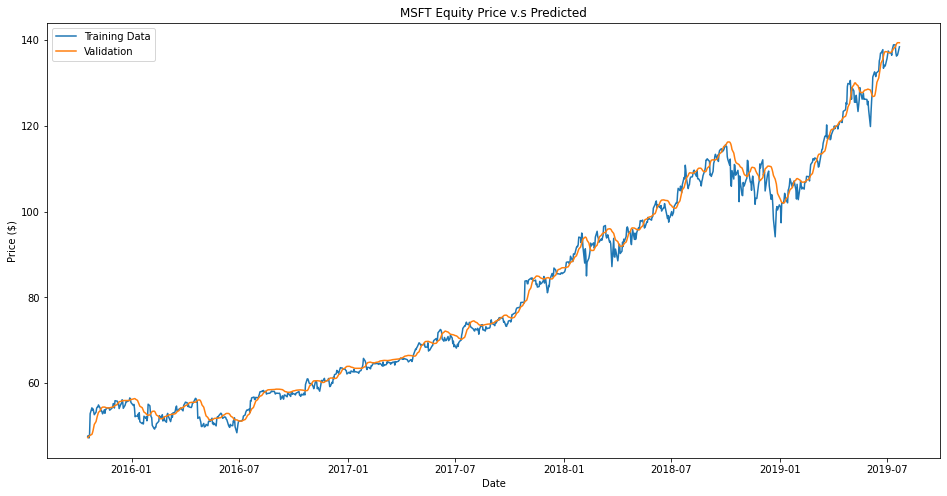

In [188]:
training_train = df_close[rolling:int(len(train_data))]
training_train['Predicted Close'] = x_train_p
plt.figure(figsize = (16,8))
plt.title('MSFT Equity Price v.s Predicted')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.plot(training_train['Close'])
plt.plot(training_train[['Predicted Close']])
plt.legend(['Training Data', 'Validation'])
plt.show()


In [189]:
#Training Model Valuation (RMSE, MSE, R^2)
MSE = np.mean(x_train_p - y_train_scaled)**2
RMSE = np.sqrt(MSE)
R2 = r2_score(x_train_p, y_train_scaled)
print ('Mean Squared Error:', MSE, '\nRoot Mean Squared Error:', RMSE, '\nR^2:', R2)


Mean Squared Error: 0.3289111326559434 
Root Mean Squared Error: 0.5735077441987539 
R^2: 0.9923859580986124


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


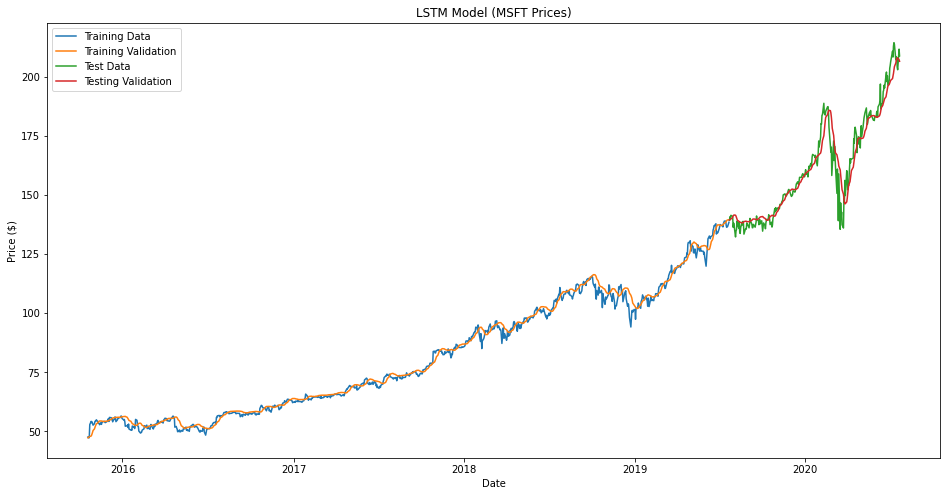

In [190]:
training_train = df_close[rolling:int(len(train_data))]
training_train['Predicted Close'] = x_train_p
validation = df_close[int(len(train_data)):]
validation['Predicted Close'] = x_test_p
plt.figure(figsize = (16,8))
plt.title('LSTM Model (MSFT Prices)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.plot(training_train['Close'])
plt.plot(training_train[['Predicted Close']])
plt.plot(validation['Close'])
plt.plot(validation['Predicted Close'])
plt.legend(['Training Data', 'Training Validation', 'Test Data', 'Testing Validation' ])
plt.show()


In [191]:
#Training Model Valuation (RMSE, MSE, R^2)
MSE = np.mean(x_test_p - y_test)**2
RMSE = np.sqrt(MSE)
R2 = r2_score(x_test_p, y_test)
print ('Mean Squared Error:', MSE, '\nRoot Mean Squared Error:', RMSE, '\nR^2:', R2)

Mean Squared Error: 0.06913247398798947 
Root Mean Squared Error: 0.26293054974268293 
R^2: 0.9109781816759812


In [192]:
#Retrain Using Whole Test Data
df_final = np.array(scaled_close)
x = []
y = []
train_amt = 60
for i in range(train_amt, len(df_final)):
    x.append(df_final[i-train_amt:i,0])
    y.append(df_final[i,0])
x, y = np.array(x), np.array(y)
x_shape = x.shape[0]
x = np.reshape(x, (x_shape, train_amt, 1))
y = np.reshape(y, (-1,1))

In [193]:
#LSTM Model #2
lstm_all = Sequential()
lstm_all.add(LSTM(train_amt, return_sequences = True, input_shape = (rolling, 1)))
lstm_all.add(LSTM(train_amt, return_sequences = True))
lstm_all.add(LSTM(train_amt))
lstm_all.add(Dense(1))
lstm_all.compile(optimizer = 'adam', loss = 'mse', metrics = ['mean_squared_error'])

In [194]:
#LSTM Model #2 Fitting
lstm_all.fit(x,y,epochs=train_amt,batch_size=64,verbose=1)

Epoch 1/60
19/19 [==============================] - 2s 91ms/step - loss: 0.0358 - mean_squared_error: 0.0358
Epoch 2/60
19/19 [==============================] - 2s 94ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 3/60
19/19 [==============================] - 2s 103ms/step - loss: 9.5903e-04 - mean_squared_error: 9.5903e-04
Epoch 4/60
19/19 [==============================] - 2s 89ms/step - loss: 7.9196e-04 - mean_squared_error: 7.9196e-04
Epoch 5/60
19/19 [==============================] - 2s 87ms/step - loss: 7.6112e-04 - mean_squared_error: 7.6112e-04
Epoch 6/60
19/19 [==============================] - 2s 89ms/step - loss: 7.5311e-04 - mean_squared_error: 7.5311e-04
Epoch 7/60
19/19 [==============================] - 2s 88ms/step - loss: 7.6231e-04 - mean_squared_error: 7.6231e-04
Epoch 8/60
19/19 [==============================] - 2s 91ms/step - loss: 6.9496e-04 - mean_squared_error: 6.9496e-04
Epoch 9/60
19/19 [==============================] - 2s 96ms/step - loss: 6.8132

In [234]:
#Projection Set
steps = 20
df_final = pd.DataFrame(scaled_close)
for x in range (0,steps):
    data = np.array(df_final[len(df_final)-train_amt + x:])
    x_project = np.array(data)
    x_project_shape = x_project.shape[0]
    x_project = np.reshape(x_project, (1, -1, 1))
    projected_data = pd.DataFrame(lstm_all.predict(x_project))
    df_final = df_final.append(projected_data)

In [235]:
#Rescaling the Dataset
df_final = mms.inverse_transform(df_final)

In [236]:
#Creating a Function For Adding Business Days
import datetime
def add_bdays(from_date, add_days):
    bdays_add = add_days
    curr_date = from_date
    while bdays_add > 0:
        curr_date += datetime.timedelta(days=1)
        weekday = curr_date.weekday()
        if weekday >= 5: 
            continue
        bdays_add -= 1
    return curr_date

In [237]:
#Creating Date Index With 10 Days Forward 
df_date = df[['Date']]
start_date = str(df_date['Date'][0])
end_date = df_date['Date'].iloc[-1]
proj_dates = []
for x in range(1,steps+1):
    proj_dates.append(add_bdays(end_date,x))
df_proj_dates = pd.DataFrame(proj_dates)
df_append_date = df_date['Date'].append(df_proj_dates)
date_array = np.array(df_append_date)
date_array.shape, df_final.shape

((1277, 1), (1277, 1))

In [241]:
#Creating New DataFrame For Forward Dates
df_new = pd.DataFrame(df_final, columns=['Projected Close'])
df_new['Date'] = date_array
df_new.set_index('Date', inplace = True)
projected_df = df_new.tail(steps)
projected_df

,Projected Close
Date,
2020-07-22,204.919714
2020-07-23,203.673040
2020-07-24,202.478726
2020-07-27,201.283791
2020-07-28,200.071644
2020-07-29,198.849974
2020-07-30,197.638677
2020-07-31,196.462590
2020-08-03,195.347714


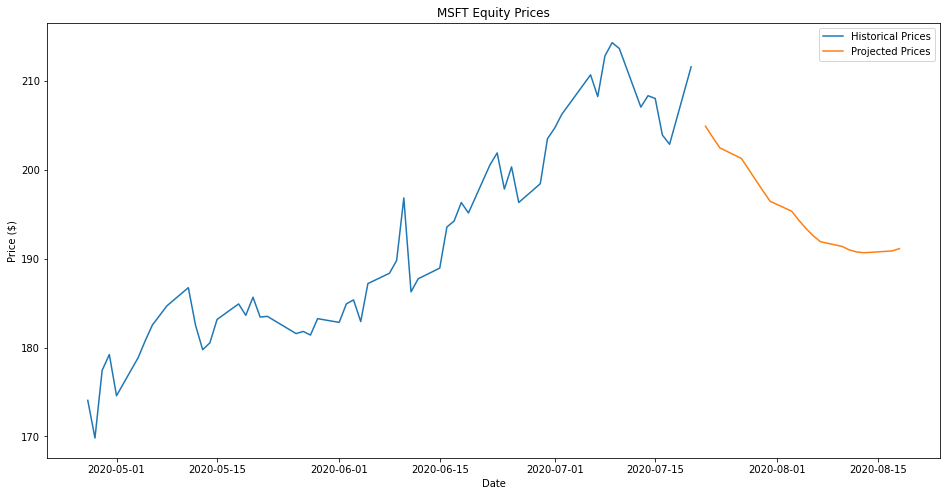

In [243]:
#Projected Values
plt.figure(figsize = (16,8))
plt.title('MSFT Equity Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.plot(df_close.iloc[-rolling:-1])
plt.plot(projected_df)
plt.legend(['Historical Prices', 'Projected Prices'])
plt.show()